In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm

from generation.dataset.data_utils import get_detector_event_df, get_detector_event_signal, get_detector_event_df_path


In [2]:
# !pip install ../..

In [3]:
_DETECTOR = 0
_EVENTS_NUM = 200


detector_signals = np.array([get_detector_event_signal(_DETECTOR, event) 
                    for event in range(_EVENTS_NUM)])

### Data preparation

In [4]:
from sklearn.preprocessing import MinMaxScaler

from generation.dataset.dataset_pytorch import SignalsDataset

In [34]:
def unify_shape(data):
    min_values = np.min(data, axis=1)
    max_values = np.max(data, axis=1)
    data = (data  - min_values[:, None]) / (max_values - min_values)[:, None]
    return data


def get_dataset(data):
    scaler = MinMaxScaler()
    data = scaler.fit_transform(data)
    dataset = SignalsDataset(data)
    return dataset, scaler, data


origin_data = detector_signals.copy()
data = unify_shape(origin_data)
data = data[~np.isnan(data).any(axis=1)]
origin_noises = data - np.mean(data, axis=0)
noises_dataset, noises_scaler, noises = get_dataset(origin_noises)

/home/pafakanov/data/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


## Model

In [4]:
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

from generation.train.wgan import run_train, generate_new_signal

wandb: Currently logged in as: whitera2bit (use `wandb login --relogin` to force relogin)
wandb: Tracking run with wandb version 0.10.1
wandb: Run data is saved locally in wandb/run-20200919_144013-kj6cbvw0
wandb: Syncing run desert-universe-8


In [5]:
SAMPLE_SIZE = 1024

# Train params
NUM_EPOCHS = 10000
BATCH_SIZE = 32
LEARNING_RATE = 1e-5
LATENT_DIM = 16
PRINT_EACH = 500
VERBOSE = 1
NO_SAVE = True
CPU = False

In [12]:
class Generator(nn.Module):
    def __init__(self, x_dim, latent_dim=100):
        super(Generator, self).__init__()
        self.x_dim = x_dim
        self.latent_dim = latent_dim
        self.in_channels = 16
        
        self.relu = nn.LeakyReLU(0.2)
        self.dropout = nn.Dropout(0.1)
        self.upsample = nn.Upsample(scale_factor=self.in_channels)
        
        self.fc = nn.Linear(self.latent_dim, self.x_dim + 12)
    
        self.conv1 = nn.Conv1d(self.in_channels, 8, 5)
        self.conv2 = nn.Conv1d(8, 4, 5)
        self.conv3 = nn.Conv1d(4, 1, 5)

    def forward(self, z):
        out = self.relu(self.fc(z))
        out = self.upsample(out.unsqueeze(1))
        out = out.view(out.shape[0], self.in_channels, self.x_dim + 12)
        out = self.relu(self.conv1(out))
        out = self.relu(self.conv2(out))
        out = self.conv3(out)

        return torch.sigmoid(out.squeeze(1))


class Discriminator(nn.Module):
    def __init__(self, x_dim):
        super(Discriminator, self).__init__()
        self.x_dim = x_dim
        self.in_channels = 16
        
        self.relu = nn.LeakyReLU(0.2)

        self.fc_final = nn.Linear(self.x_dim // self.in_channels - 4, 1)

        self.conv1 = nn.Conv1d(self.in_channels, 8, 3)
        self.conv2 = nn.Conv1d(8, 1, 3)
#         self.conv3 = nn.Conv1d(4, 1, 3)

    def forward(self, signal):
        out = signal.view(signal.shape[0], self.in_channels, self.x_dim // self.in_channels)
        out = self.relu(self.conv1(out))
        out = self.relu(self.conv2(out))
#         out = self.relu(self.conv3(out))

        out = out.squeeze(1)
        out = self.fc_final(out)

        return out

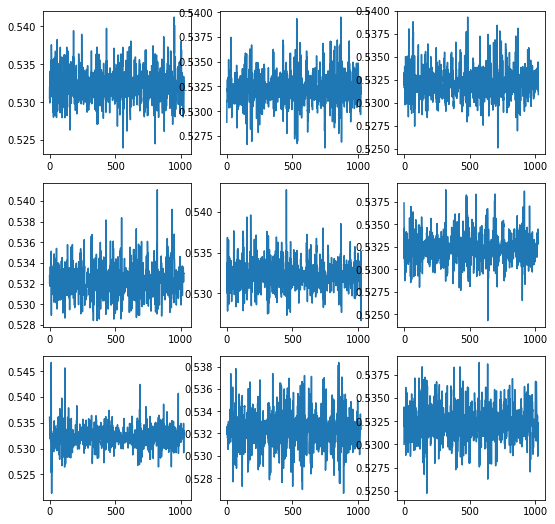

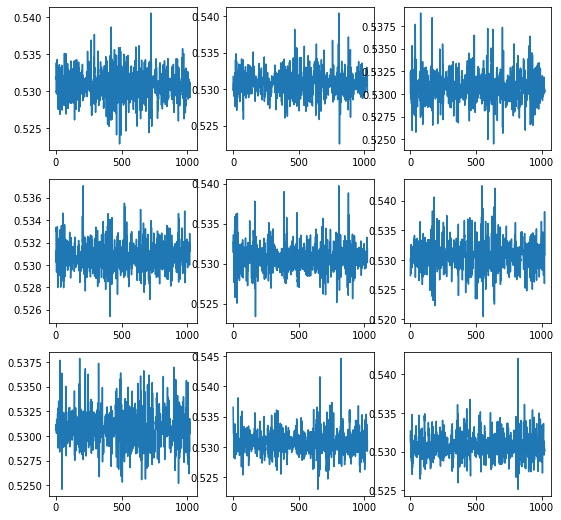

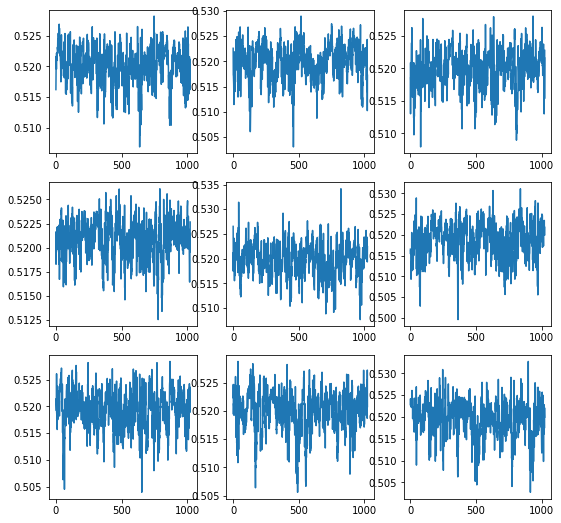

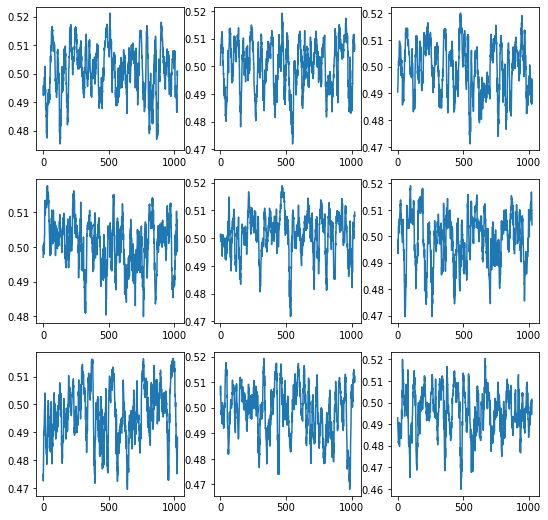

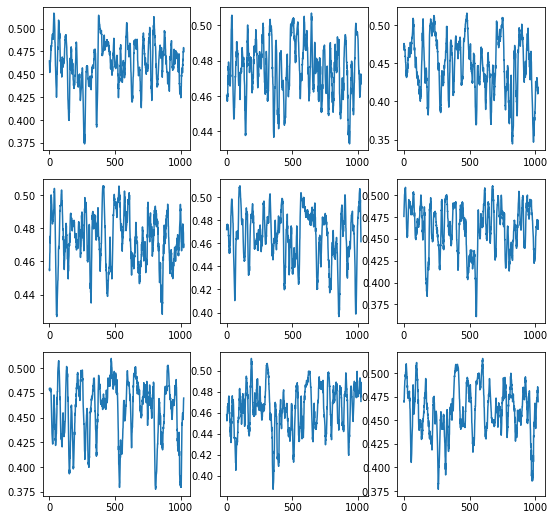

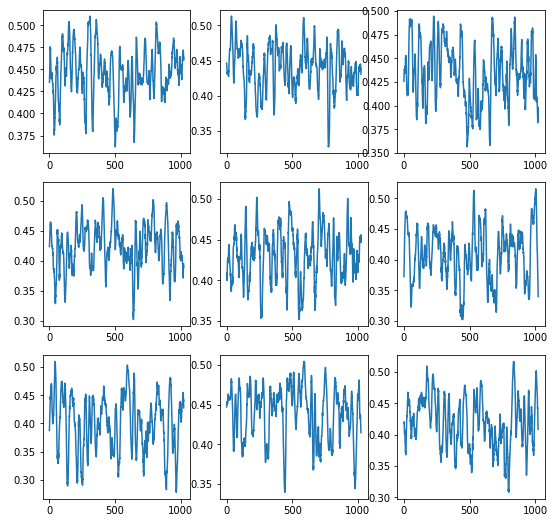

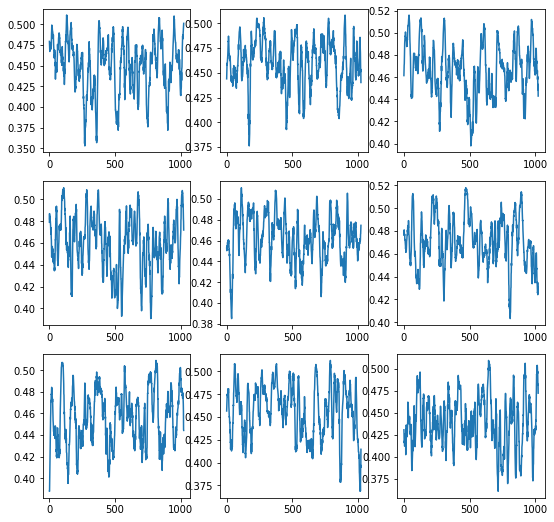

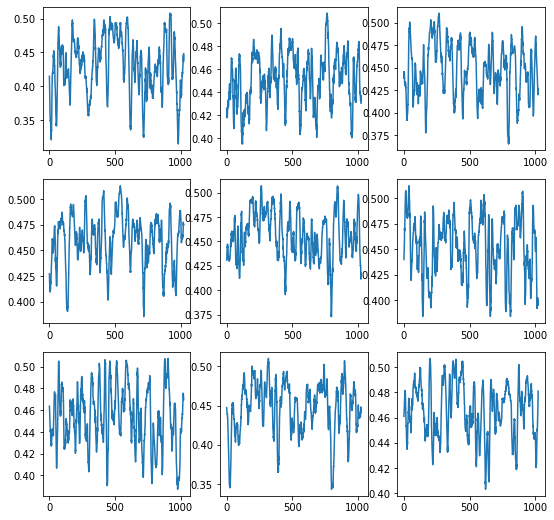

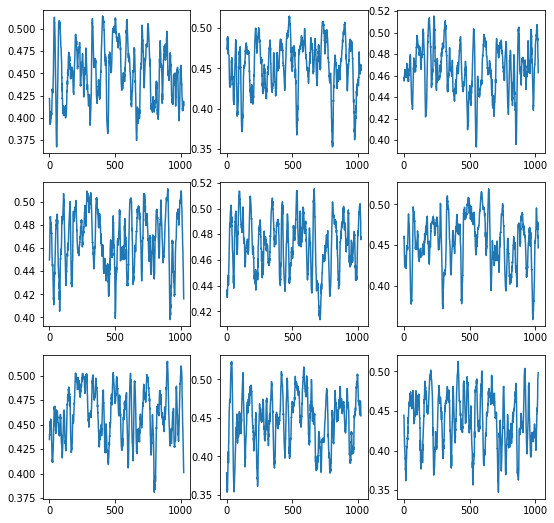

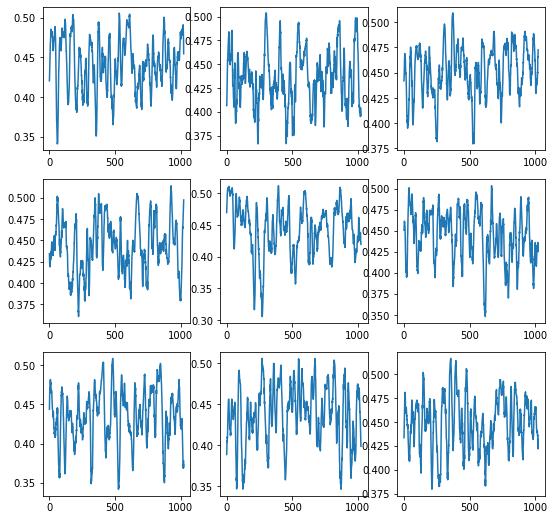

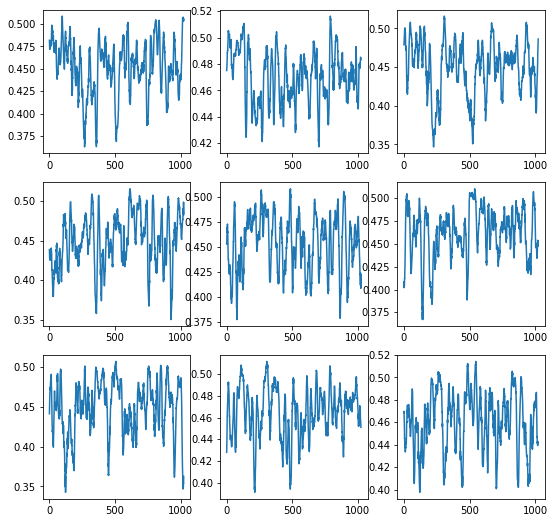

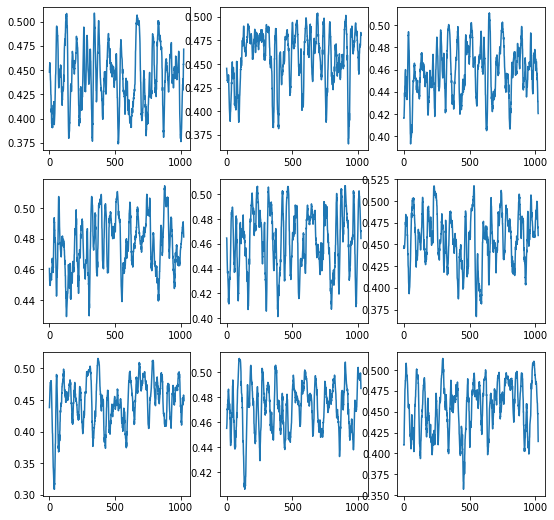

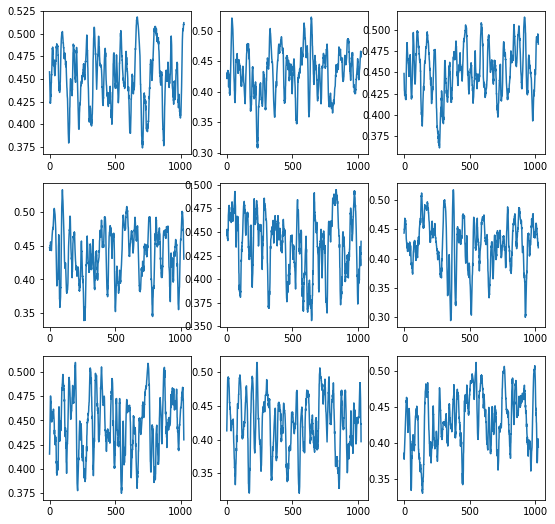

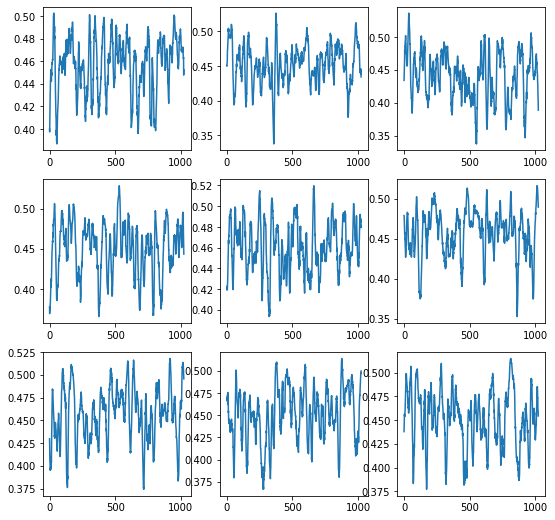

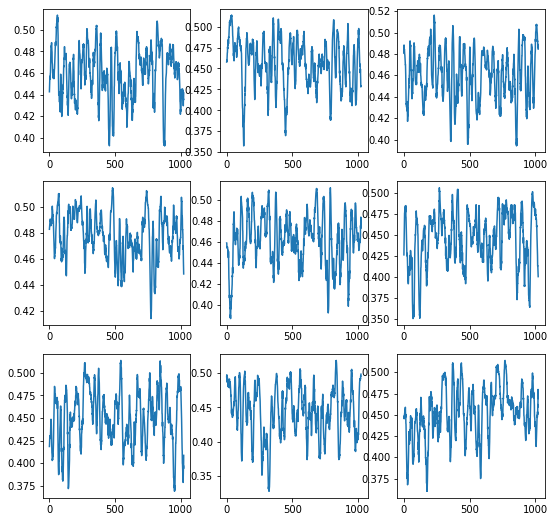

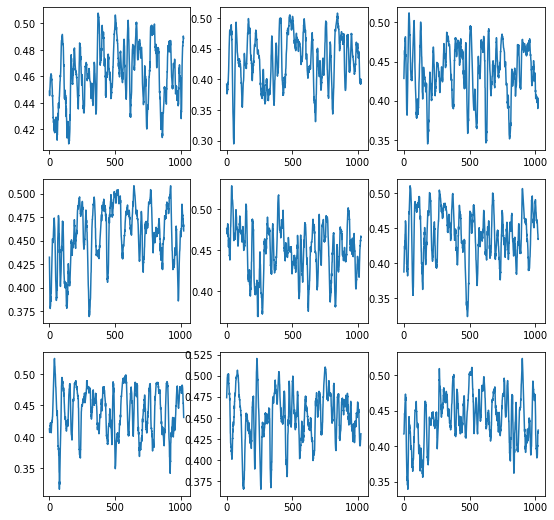

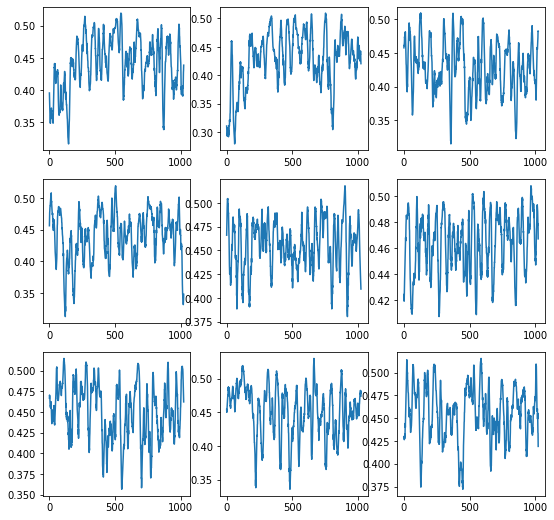

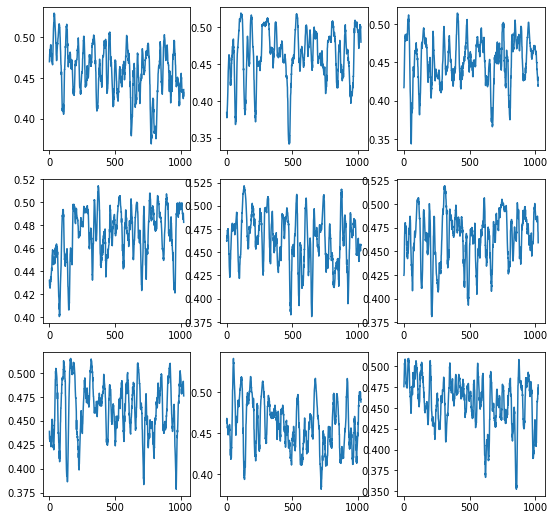

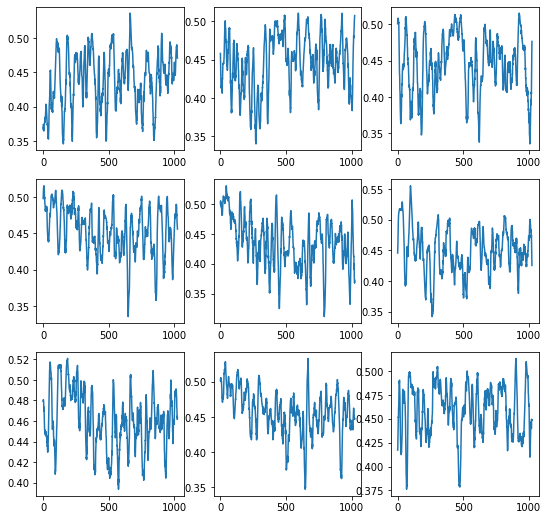

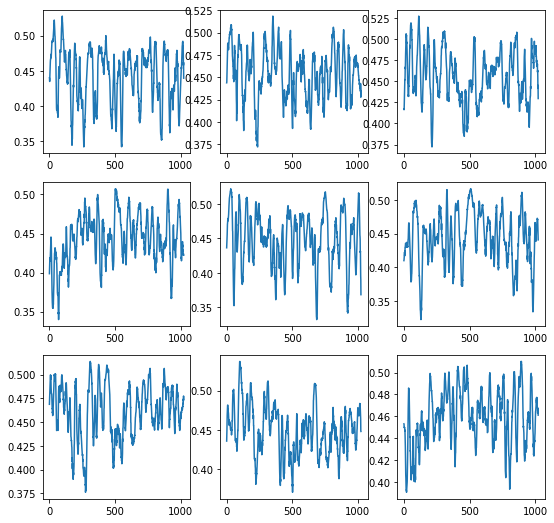

In [13]:
noises_generator = run_train(noises_dataset, \
          Generator, Discriminator, \
          latent_dim=LATENT_DIM, \
          sample_size=SAMPLE_SIZE, \
          learning_rate=LEARNING_RATE, \
          num_epochs=NUM_EPOCHS, \
          batch_size=BATCH_SIZE, \
          print_each=PRINT_EACH, \
          verbose=VERBOSE, \
          no_save=NO_SAVE, \
          cpu=CPU)

# angles_generator = run_train(angles_dataset, \
#           latent_dim=LATENT_DIM, \
#           sample_size=SAMPLE_SIZE, \
#           learning_rate=LEARNING_RATE, \
#           num_epochs=NUM_EPOCHS, \
#           batch_size=BATCH_SIZE, \
#           print_each=PRINT_EACH, \
#           verbose=VERBOSE, \
#           no_save=NO_SAVE)

# norms_generator = run_train(norms_dataset, \
#           latent_dim=LATENT_DIM, \
#           sample_size=SAMPLE_SIZE, \
#           learning_rate=LEARNING_RATE, \
#           num_epochs=NUM_EPOCHS, \
#           batch_size=BATCH_SIZE, \
#           print_each=PRINT_EACH, \
#           verbose=VERBOSE, \
#           no_save=NO_SAVE)

In [14]:
def get_random_signal(data):
    return data[np.random.choice(range(len(data)))]

def get_closest(signal, data):
    diffs = np.mean((data - signal) ** 2, axis=1)
    return data[np.argmin(diffs)]

def inspect_results(generated, origin, rows_num=3, cols_num=3):
    f, ax = plt.subplots(rows_num, cols_num, figsize=(12, 12))

    for i in range(rows_num * cols_num):
        generated_el = get_random_signal(generated)
        closest_origin = get_closest(generated_el, origin)
        ax[i // rows_num][i % cols_num].plot(generated_el, alpha=0.7)
        ax[i // rows_num][i % cols_num].plot(closest_origin, alpha=0.7)
        ax[i // rows_num][i % cols_num].legend(['Generated', 'Origin'])
    plt.show()

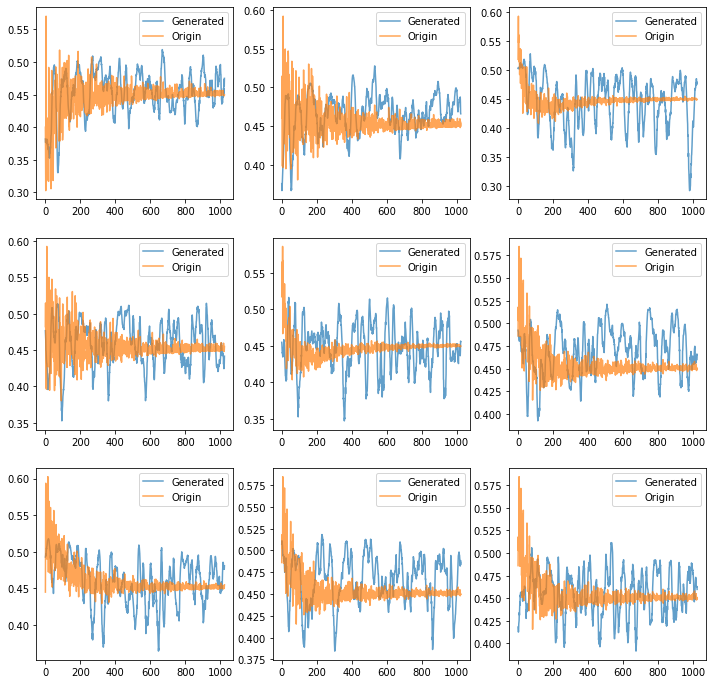

In [15]:
generated_noises = np.array([generate_new_signal(noises_generator)[0] for i in range(len(data))])
inspect_results(generated_noises, noises)

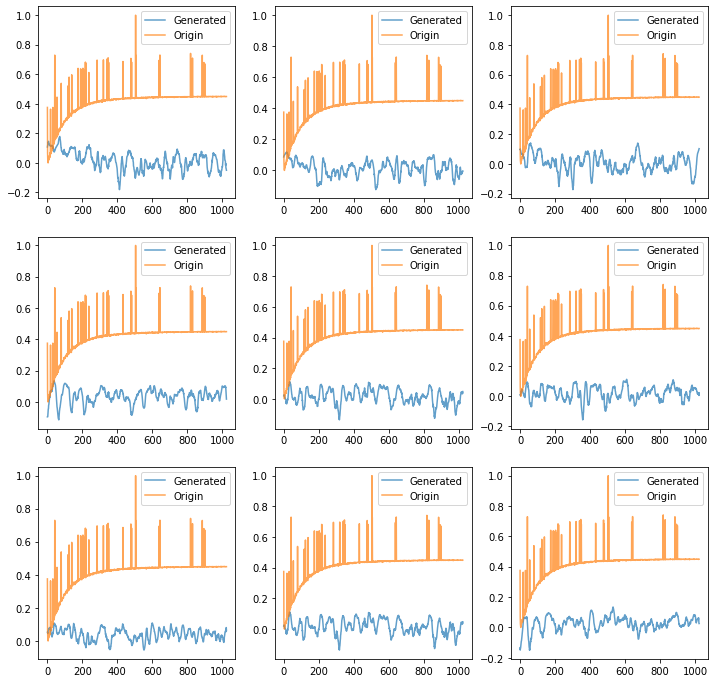

In [16]:
generated_noises = noises_scaler.unscale(generated_noises)
inspect_results(generated_noises, noises)

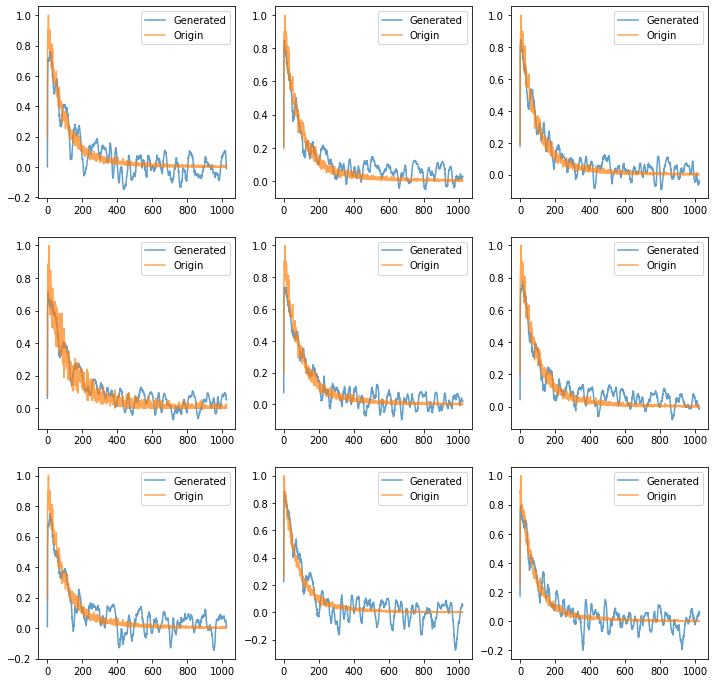

In [22]:
generated_data = generated_noises + np.mean(data, axis=0)
inspect_results(generated_data, data)

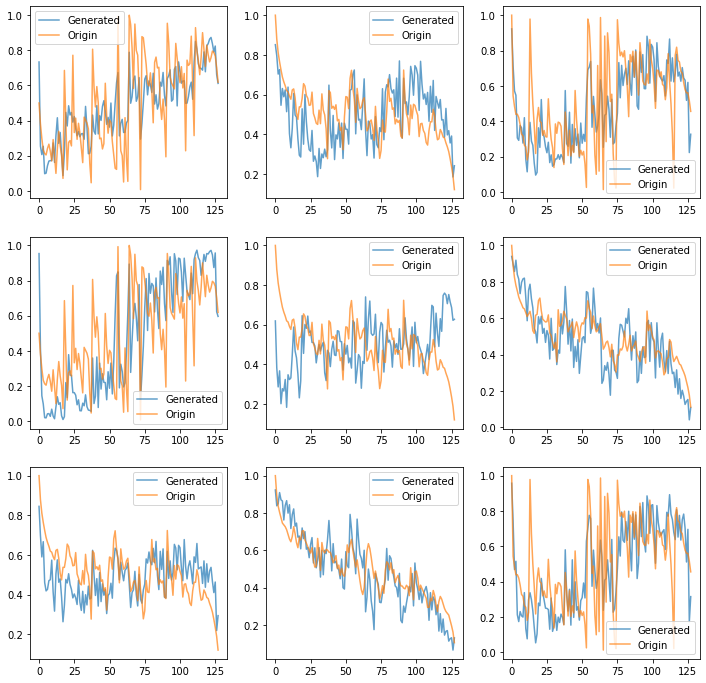

In [93]:
generated_angles = np.array([generate_new_signal(angles_generator)[0] for i in range(len(data))])
inspect_results(generated_angles, angles)

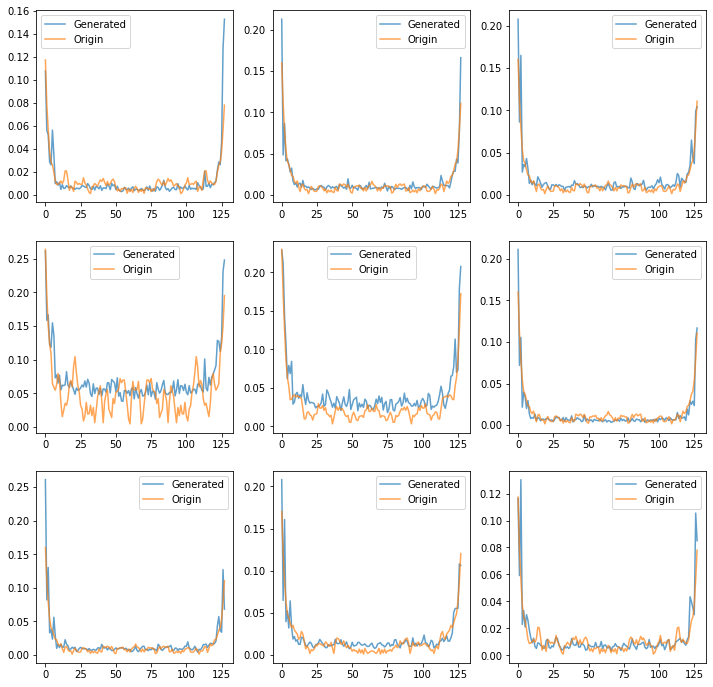

In [94]:
generated_norms = np.array([generate_new_signal(norms_generator)[0] for i in range(len(data))])
inspect_results(generated_norms, norms)

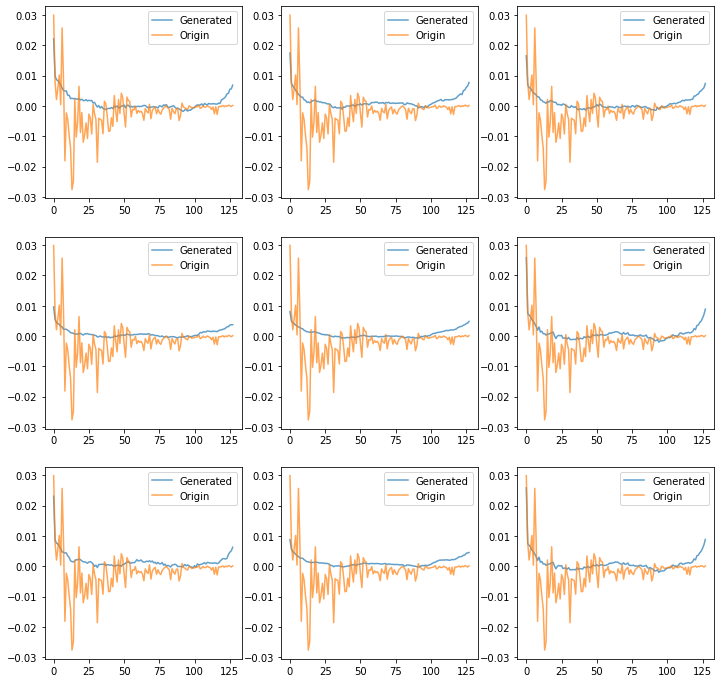

In [97]:
generated_noises = inverse(generated_norms, generated_angles)
inspect_results(generated_noises, origin_noises)

IndexError: index 60 is out of bounds for axis 0 with size 2

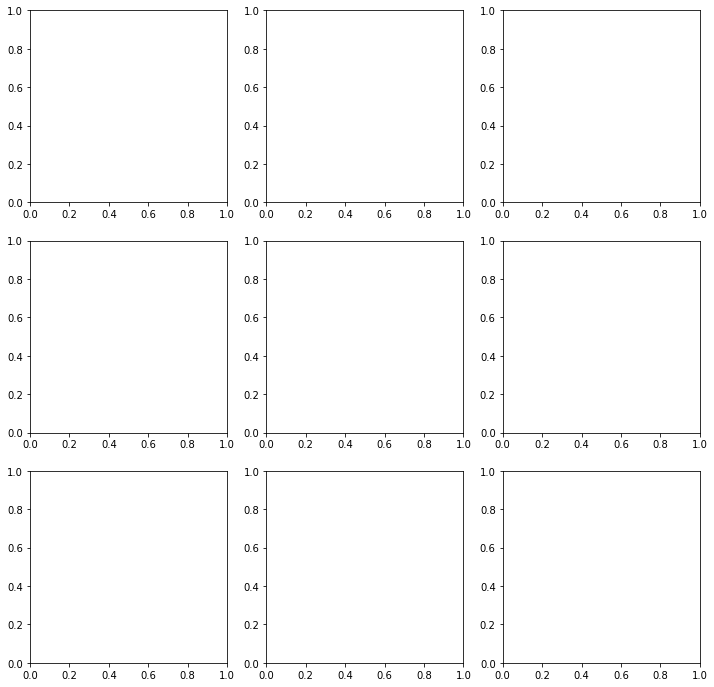

In [57]:
rows_num = 3
cols_num = 3
f, ax = plt.subplots(rows_num, cols_num, figsize=(12, 12))

for i in range(rows_num * cols_num):
    generated_noise = get_random_signal(generated_noises)
    closest_origin = get_closest(generated_noise, noises)
    ax[i // rows_num][i % cols_num].plot(generated_noise, alpha=0.7)
    ax[i // rows_num][i % cols_num].plot(closest_origin, alpha=0.7)
    ax[i // rows_num][i % cols_num].legend(['Generated', 'Origin'])
plt.show()

In [12]:
generated_noises = inverse(generated_noises)
generated_noises = scaler.unscale(generated_noises)
generated_data = np.mean(data, axis=0) + generated_noises

/home/pafakanov/data/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/pafakanov/data/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/pafakanov/data/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/pafakanov/data/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/pafakanov/data/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary 

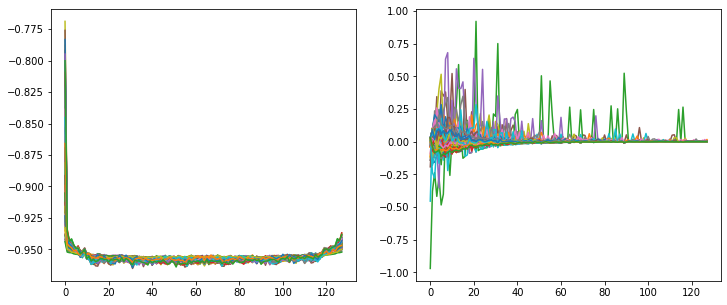

In [14]:
f, ax = plt.subplots(1, 2, figsize=(12, 5))
for noise in generated_noises:
    ax[0].plot(noise)
for noise in origin_noises:
    ax[1].plot(noise)

/home/pafakanov/data/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/pafakanov/data/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/pafakanov/data/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/pafakanov/data/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/pafakanov/data/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary 

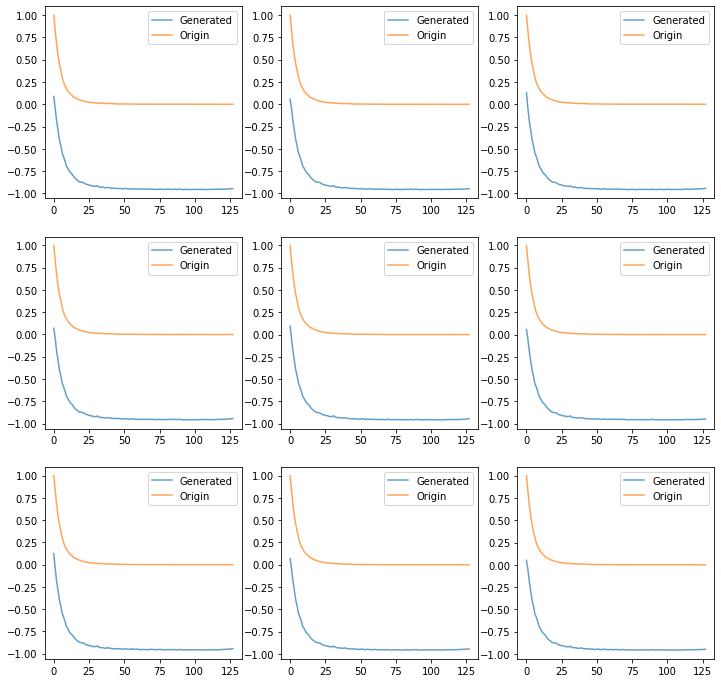

In [15]:
rows_num = 3
cols_num = 3
f, ax = plt.subplots(rows_num, cols_num, figsize=(12, 12))

for i in range(rows_num * cols_num):
    generated_signal = get_random_signal(generated_data)
    closest_origin = get_closest(generated_data, data)
    ax[i // rows_num][i % cols_num].plot(generated_signal, alpha=0.7)
    ax[i // rows_num][i % cols_num].plot(closest_origin, alpha=0.7)
    ax[i // rows_num][i % cols_num].legend(['Generated', 'Origin'])
plt.show()

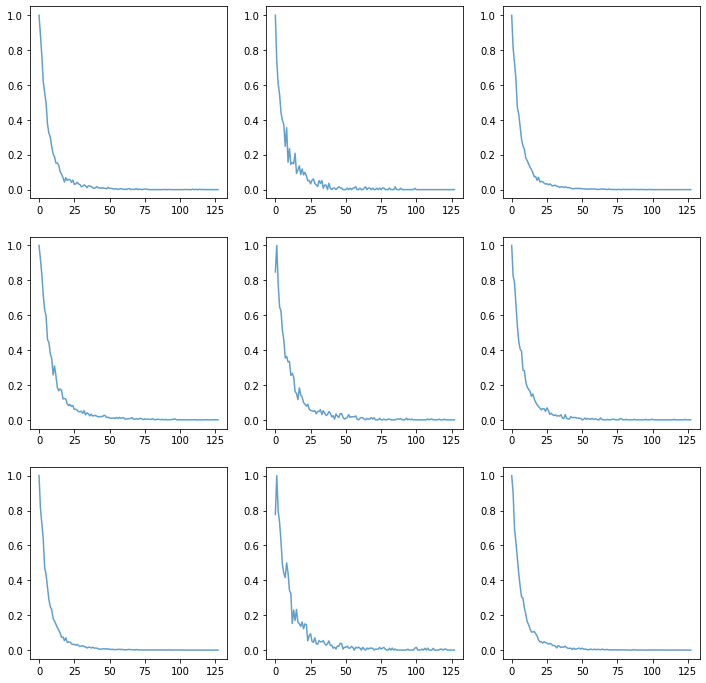

In [17]:
rows_num = 3
cols_num = 3
f, ax = plt.subplots(rows_num, cols_num, figsize=(12, 12))

for i in range(rows_num * cols_num):
#     generated_signal = generated_data)
#     closest_origin = get_closest(generated_data, data)
    ax[i // rows_num][i % cols_num].plot(get_random_signal(data), alpha=0.7)
#     ax[i // rows_num][i % cols_num].plot(closest_origin, alpha=0.7)
#     ax[i // rows_num][i % cols_num].legend(['Generated', 'Origin'])
plt.show()